# Comparing by critical lifetime ratio (PHASOR part)
Simulating the lifetime decay from 3.07 to 2.5, for 20 points. Amplitude the same as before. Derive the index of separability to obtain critical
lifetime ratio.

In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import convolve
from scipy import stats
from sympy import symbols, solve, Eq, Function, nsolve
from sympy.matrices import Matrix
import sympy as sp
from scipy.optimize import curve_fit
from lmfit import Model, Parameters
import lmfit
import inspect
import pandas as pd
import numdifftools
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.optimize import fsolve
from TCSPC import *

plt.style.use('seaborn-v0_8-deep')

In [2]:
# define functions from phasor.ipynb
def phasor_eq_func_A_vary(A_tau_arr,phasor):
    '''Function to be passed to phasor_solve_num to solve for A_tau array (A1,A2, tau1, tau2)
       Input: 
       A_tau_arr    parameter array A1,A2 tau1, tau2
       phasor       phasor array from Simulation().phasor to be resolved '''
    n = int(len(A_tau_arr)/2) #number of components
    y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n]) for j in range(n)]) #pure multiexponential
    y = np.convolve(y,EGFP.ker,'full')[:EGFP.n_bins]/np.sum(EGFP.ker)
    w,phasor_test = EGFP.phasor_fft(y=y) 
    A_sum = 1-np.sum(A_tau_arr[:n]) #A1,...An sum to 1
    phasor_compare = phasor_test.real[0:2*n-1]-phasor.real[0:2*n-1] #solve for A_tau_arr such that it gives 0
    return [A_sum]+list(phasor_compare) #

def phasor_eq_func(A_tau_arr,phasor):
    '''Function to be passed to phasor_solve_num to solve for A_tau array (A1, tau1, tau2) (2n-1)
       Input: 
       A_tau_arr    parameter array A1 tau1, tau2
       phasor       phasor array from Simulation().phasor to be resolved '''
    n = int((len(A_tau_arr)+1)/2) #number of components
    #A_tau_arr = np.insert(A_tau_arr,n-1,1-np.sum(A_tau_arr[:n-1])) #insert An
    y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n-1]) for j in range(n-1)]) #pure multiexponential
    y  += (1-np.sum(A_tau_arr[:n-1]))*np.exp(-EGFP.t / A_tau_arr[-1]) #last component
    y = np.convolve(y,EGFP.ker,'full')[:EGFP.n_bins]/np.sum(EGFP.ker)
    w,phasor_test = EGFP.phasor_fft(y=y) 
    phasor_compare = phasor_test.real[0:2*n-1]-phasor.real[0:2*n-1] #solve for A_tau_arr such that it gives 0
    return phasor_compare

def phasor_solve_num(phasor,x0):
    '''Solve for amplitude and lifetimes numerically using 3 phasors for 3 parameters (A1, tau1, tau2)
       phasor      phasor array (Simulation().phasor) to be resolved
       x0          initial guess for a_tau_arr'''
    return fsolve(phasor_eq_func,x0=x0,args = phasor)

In [3]:
# simulation for different lifetimes
tau_array = np.linspace(2.5,3.07,20)
par_arr = np.zeros((20,100,3))
for i in range(len(tau_array)):
    tau2 = tau_array[i]
    EGFP = Phasor([0.497,0.503],[2.5,tau2])
    for j in range(len(EGFP.phasor_data)): #no background
        phasor = EGFP.phasor_data[j]
        par_arr[i,j] = phasor_solve_num(phasor,[EGFP.amp[0],*EGFP.tau])

C:\Users\xujia\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\xujia\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\xujia\AppData\Local\Temp\ipykernel_20568\1872761685.py:23: RuntimeWarning: overflow encountered in exp
  y  += (1-np.sum(A_tau_arr[:n-1]))*np.exp(-EGFP.t / A_tau_arr[-1]) #last component
C:\Users\xujia\AAA\TCSPC.py:168: RuntimeWarning: invalid value encountered in divide
  phasor = (np.fft.fft(y).T/y_sum).T/np.fft.fft(ker)*np.sum(ker)


In [17]:
# calculate means and standard deviations
mean = np.mean(par_arr,axis = 1)
std = np.std(par_arr,axis = 1)

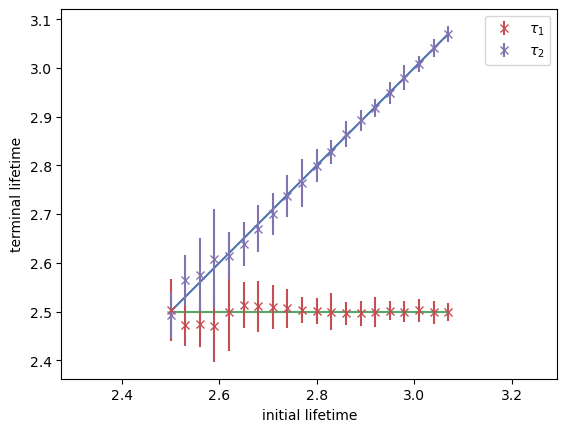

In [5]:
# plot 1D graph for simulated data
plt.figure()
plt.axis("equal")
plt.plot(tau_array,tau_array)
plt.plot([2.5,3.07],[2.5,2.5])
plt.errorbar(tau_array,mean[:,1],yerr=std[:,1],fmt = 'x',label=rf'$\tau_{1}$')
plt.errorbar(tau_array,mean[:,2],yerr=std[:,2],fmt = 'x',label=rf'$\tau_{2}$')

plt.xlabel("initial lifetime")
plt.ylabel("terminal lifetime")
plt.legend()
plt.show()

## Simulation for lifetimes

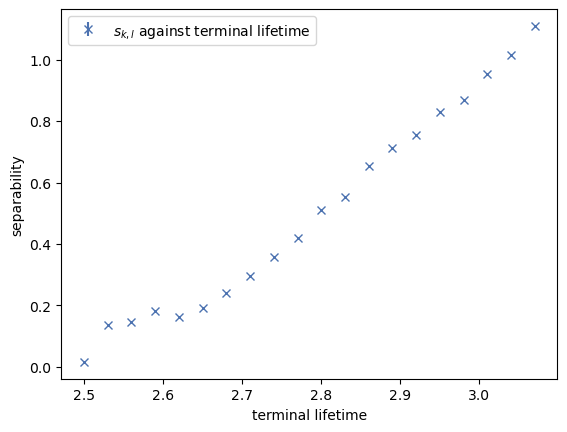

In [21]:
# calculate separability and plot it against terminal lifetime
separability_kl = abs(mean[:,1]-mean[:,2]) / (np.sqrt(std[:,1])+np.sqrt(std[:,2]))**0.5

plt.figure()
plt.errorbar(tau_array,separability_kl,yerr=0,fmt = 'x',label="$s_{k,l}$ against terminal lifetime")

plt.xlabel("terminal lifetime")
plt.ylabel("separability")
plt.legend()
plt.show()

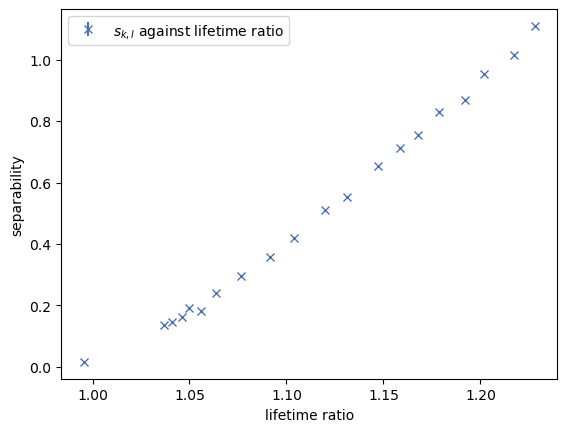

In [22]:
# plot separability against lifetime ratio
plt.figure()
plt.errorbar(mean[:,2]/mean[:,1],separability_kl,yerr=0,fmt = 'x',label="$s_{k,l}$ against lifetime ratio")

plt.xlabel("lifetime ratio")
plt.ylabel("separability")
plt.legend()
plt.show()

In [24]:
# give the separabilitis and the critical lifetime where the lifetimes start to be separable
s_min = 0
for i in range(20):
    if separability_kl[i] < 1: 
        print("separability_kl is ", separability_kl[i], ", it's nonseparatable.")
    else:
        s_min = i
        print("separability_kl is ", separability_kl[i])
        print(f"The lifetimes are separable from the {i+1}th data. ")
        print(f"Thus, the critical lifetime ratio is {mean[i,2]/mean[i,1]}")
        break        

separability_kl is  0.016143960997100967 , it's nonseparatable.
separability_kl is  0.13737247133628994 , it's nonseparatable.
separability_kl is  0.14548203459267553 , it's nonseparatable.
separability_kl is  0.1804809347870197 , it's nonseparatable.
separability_kl is  0.1629898493019303 , it's nonseparatable.
separability_kl is  0.1909580514343261 , it's nonseparatable.
separability_kl is  0.23900816798832153 , it's nonseparatable.
separability_kl is  0.29524680210879223 , it's nonseparatable.
separability_kl is  0.3591412212434064 , it's nonseparatable.
separability_kl is  0.41801118494635375 , it's nonseparatable.
separability_kl is  0.5093891477663497 , it's nonseparatable.
separability_kl is  0.5519740250891408 , it's nonseparatable.
separability_kl is  0.6527300109898883 , it's nonseparatable.
separability_kl is  0.7128090816176782 , it's nonseparatable.
separability_kl is  0.753471794705311 , it's nonseparatable.
separability_kl is  0.8311621861163535 , it's nonseparatable.
se

## Simulation for number of photons

In [12]:
# generate data with different number of photons by EGFP
n_photon_arr = np.logspace(4,9,20).astype(int)
result_array = np.zeros((20,20,10,3))
for i in range(20):
    EGFP.n_photon = n_photon_arr[i]
    for j in range(20): 
        EGFP.tau = [2.5,tau_array[j]]
        for k in range(10): #no background
            EGFP.repeat_sim(10)
            phasor = EGFP.phasor_data[k]
            result_array[i,j,k] = phasor_solve_num(phasor,[EGFP.amp[0],*EGFP.tau])        

C:\Users\xujia\AppData\Local\Temp\ipykernel_20568\1872761685.py:22: RuntimeWarning: overflow encountered in exp
  y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n-1]) for j in range(n-1)]) #pure multiexponential
C:\Users\xujia\AppData\Local\Temp\ipykernel_20568\1872761685.py:22: RuntimeWarning: overflow encountered in multiply
  y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n-1]) for j in range(n-1)]) #pure multiexponential


In [25]:
# calculate para
mean_new = np.mean(result_array,axis = 2)
std_new = np.std(result_array,axis = 2)

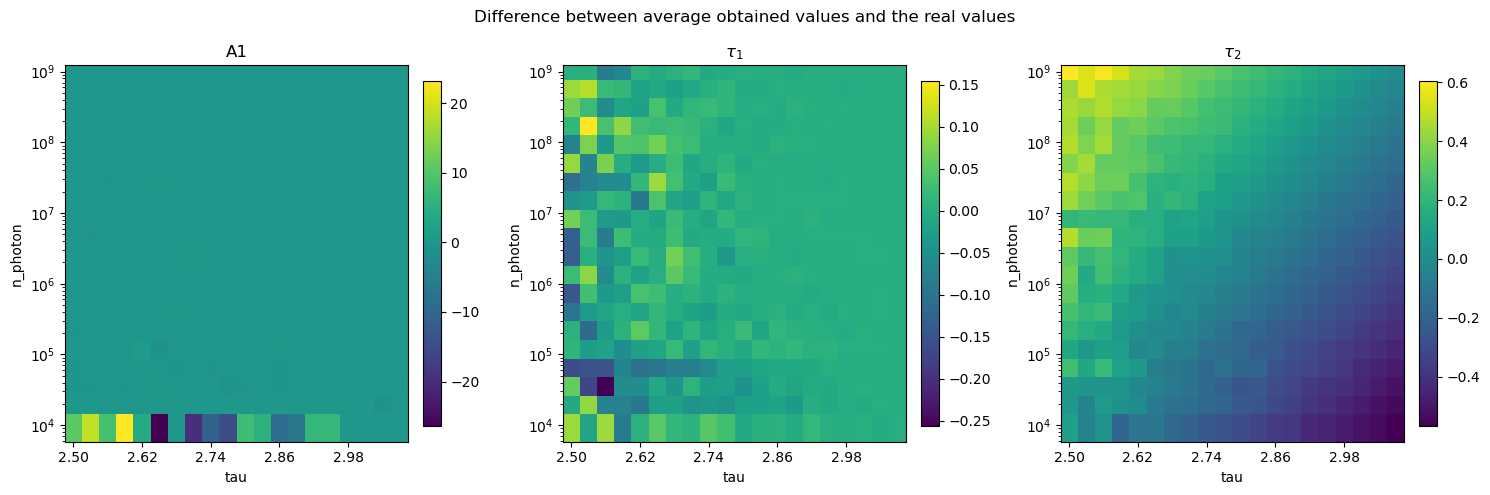

In [26]:
# plot 2D graphs
N,T2 = np.meshgrid(n_photon_arr,tau_array)
N,T1 = np.meshgrid(n_photon_arr,np.ones(20)*2.5)
N,A1 = np.meshgrid(n_photon_arr,np.ones(20)*0.497)
true = [A1,T1,T2]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Difference between average obtained values and the real values')
for i in range(3):
    cax = axs[i].pcolormesh(T2,N,mean_new[:,:,i]-true[i])
    axs[i].set_title('First Image')
    fig.colorbar(cax, ax=axs[i], fraction=0.046, pad=0.04)
    axs[i].set_yscale('log')
    axs[i].set_aspect('auto')
    axs[i].set_xticks(tau_array[::4])
    axs[i].set_xlabel(f'tau')
    axs[i].set_ylabel(f'n_photon')
    axs[i].set_title(['A1',r'$\tau_1$',r'$\tau_2$'][i])

plt.tight_layout()

In [27]:
# save the figures
fig.savefig('fig/tau2_n_photon_phasor.pdf')

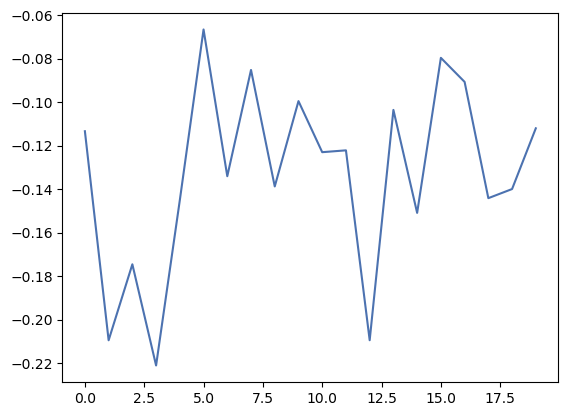

In [28]:
# show the critical points by 1D figure
plt.plot(mean_new[4,:,1]-T2[4,:])